In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from utils import dataset, plots, metrics

from torch.utils.data import DataLoader

import math

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 575, in _log_error
    f.result()
  File "/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/mnt/anaconda3/envs/nndl/lib/python3.9/site-packages/traitlets/traitlets.py", line 649, in get
    value = self._validate(obj, default)
  File "/mnt/anaco

In [2]:
path = '/mnt/POD/NNDL_gd/code/GW_TS_classification_copy/models/'

In [3]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__() 

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=32, 
                      kernel_size=4, 
                      stride=1),
            nn.MaxPool1d(kernel_size=2, stride = 1), # default stride: kernel_size 
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, 
                      out_channels=64, 
                      kernel_size=4, 
                      stride=2),
            nn.MaxPool1d(kernel_size=2, stride = 1),
            nn.Dropout(0.1),
            nn.ReLU(True))
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=8, 
                      stride=2),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True))

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=16, 
                      stride=4),
            nn.MaxPool1d(kernel_size=4, stride = 1),
            nn.Dropout(0.25),
            nn.ReLU(True),
            nn.AdaptiveAvgPool1d(1),
            nn.Dropout(0.1)
        )
        
        self.lin = nn.Sequential(
            nn.Linear(in_features=256, 
                      out_features=64),
            nn.Linear(in_features=64, 
                      out_features=2))
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # apply conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.squeeze(-1) # remove last dim that is 1
        # apply linear layer
        out = self.lin(x)
        # apply softmax
        out = self.softmax(out)
        return out 
    

In [4]:
cnn_model = CNN()
cnn_model.load_state_dict(torch.load(path+'CNN_trained.torch'))

<All keys matched successfully>

In [ ]:
def plot_model_params(model, save_path=None, normalize=True):

    # collect all parameters (weights and biases) with names
    params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]

    # group by layer name (everything before the last ".")
    layers = {}
    for name, p in params:
        layer_name, param_type = name.rsplit('.', 1)
        layers.setdefault(layer_name, {})[param_type] = p

    n_layers = len(layers)
    fig, axes = plt.subplots(n_layers, 2, figsize=(12, 4*n_layers))

    if n_layers == 1:
        axes = axes.reshape(1, 2)  # ensure 2D array even for single layer

    for row, (layer_name, param_dict) in enumerate(layers.items()):
        for col, param_type in enumerate(["weight", "bias"]):
            ax = axes[row, col]
            if param_type in param_dict:
                values = param_dict[param_type].detach().cpu().numpy().flatten()
                ax.hist(
                    values,
                    density=normalize,  
                    color="steelblue",
                    alpha=0.7,
                    edgecolor="black"
                )
                ax.set_title(
                    f"{layer_name}.{param_type}\n"
                    f"mean={values.mean():.4f}, std={values.std():.4f}"
                )
                ax.set_xlabel("Value")
                ax.set_ylabel("Density" if normalize else "Frequency")
            else:
                ax.axis("off")  # blank subplot if no bias

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

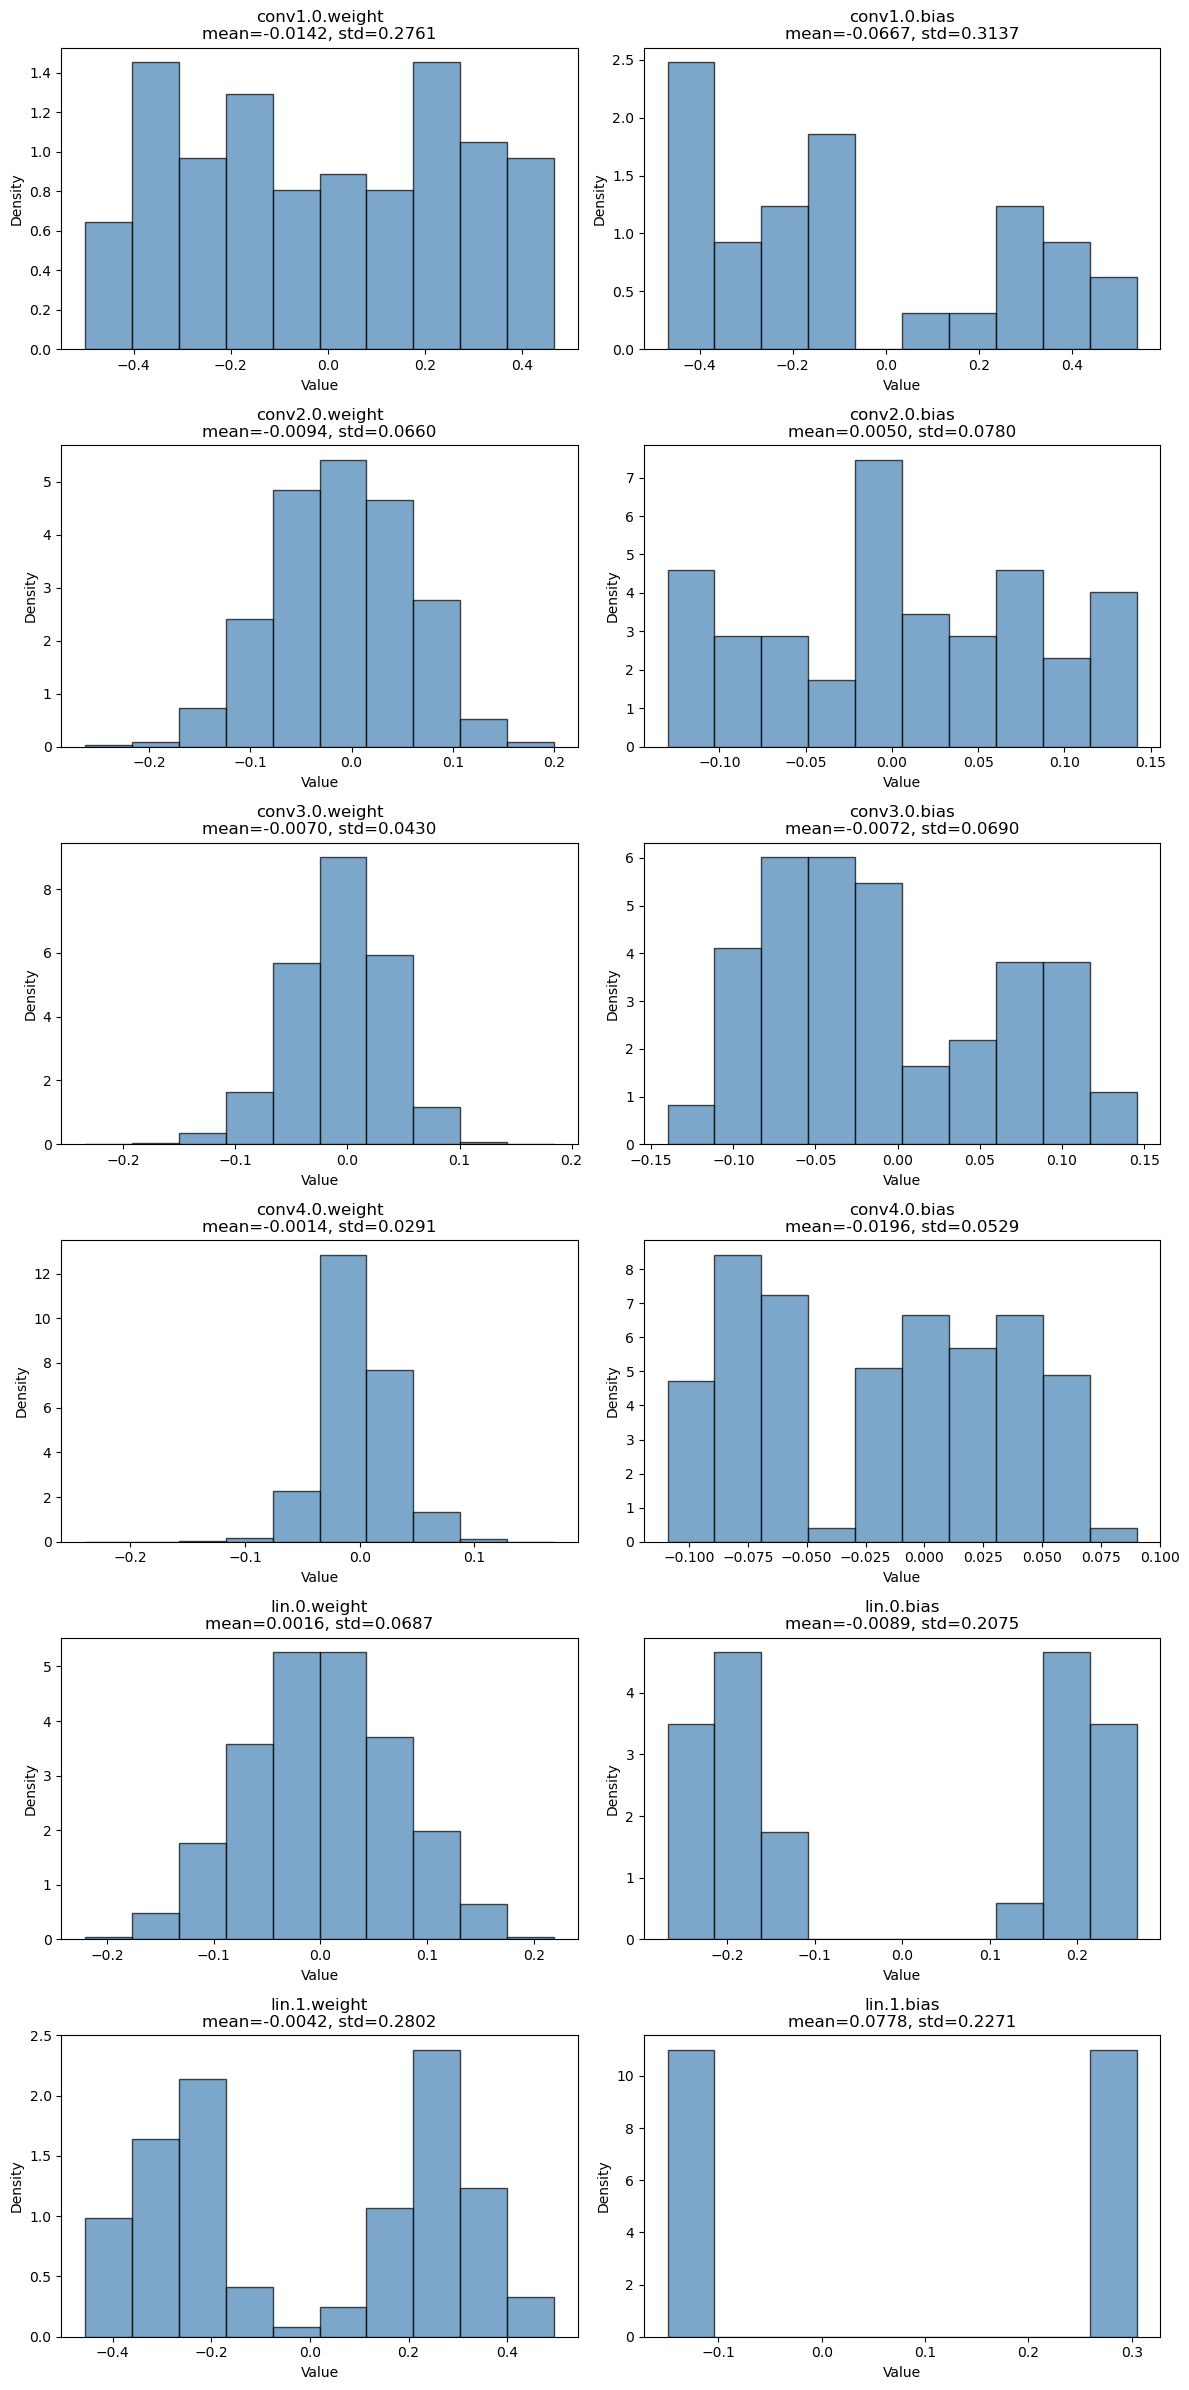

In [14]:
plot_model_params(cnn_model)

In [10]:
def plot_model_activations(model, dataloader, device, max_batches=1, bins=None, save_path=None):
    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu().numpy().flatten()
        return hook

    # Register hooks
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, (torch.nn.Conv1d, torch.nn.Linear)):
            hooks.append(layer.register_forward_hook(get_activation(name)))

    # Forward pass
    model.eval()
    model.to(device)
    with torch.no_grad():
        for i, (xb, yb) in enumerate(dataloader):
            xb = xb.float().to(device)
            _ = model(xb)
            if i + 1 >= max_batches:
                break

    # Remove hooks
    for h in hooks:
        h.remove()

    if not activations:
        print("No activations collected.")
        return

    # Determine layout: 2 columns
    n_layers = len(activations)
    n_cols = 2
    n_rows = math.ceil(n_layers / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # flatten in case of multiple rows

    for ax, (name, act) in zip(axes, activations.items()):
        ax.grid(alpha=0.3)
        ax.hist(act, bins=bins if bins is not None else 'auto',
                color='coral', alpha=0.7, edgecolor='grey')
        ax.set_title(f"{name}\nmean={act.mean():.4f}, std={act.std():.4f}")
        ax.set_xlabel("Activation value")
        ax.set_ylabel("Frequency")

    # Turn off unused axes
    for ax in axes[n_layers:]:
        ax.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=400)
    else:
        plt.show()

In [6]:
if torch.cuda.is_available():
    print('GPU availble')
    # define the device
    device = torch.device("cuda")
else:
    print('GPU not availble')
    device = torch.device("cpu")

GPU availble


In [7]:
test_set = dataset.GW_dataset('test', n_classes=2, std=False)
test_DL = DataLoader(test_set, batch_size=32, num_workers=4)

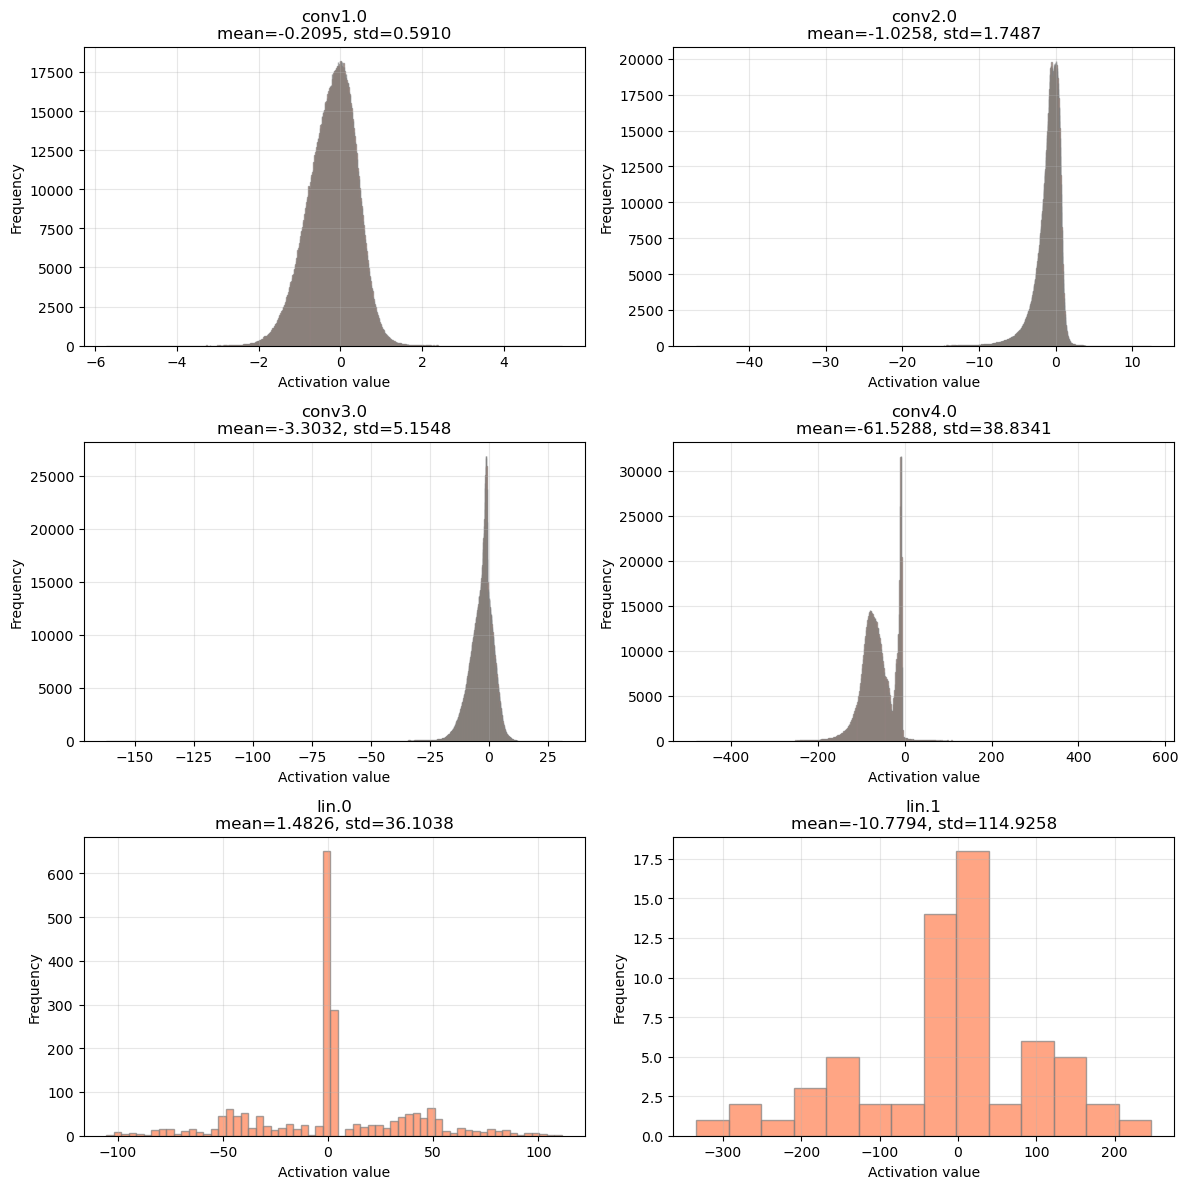

In [11]:
plot_model_activations(cnn_model, test_DL, device)

In [ ]:
# test
print('\n-- Testing  \n')
cnn_model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for sample in test_DL:
        xb = sample[0].float().to(device)
        yb = sample[1].long().to(device)

        out = cnn_model(xb)

        preds = torch.argmax(out, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(yb.cpu().numpy())
        all_probs.append(out.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [ ]:
# ROC
classes = [f"Class {i}" for i in range(2)]
fpr, tpr, roc_auc = metrics.compute_roc(all_probs, all_labels, num_classes=2)

# plot ROC
plots.plot_ROC('cnn_test', fpr, tpr, roc_auc)

In [27]:
# save AUC values + FPR and TPR points
roc_file = './model_info/'+'cnn_test'+"_ROC.txt"
with open(roc_file, "w") as f:
    for i, cls in enumerate(classes):
        f.write(f"{cls} AUC: {roc_auc[i]:.4f}\n")
        f.write(f"{cls} FPR: {','.join([f'{x:.6f}' for x in fpr[i]])}\n")
        f.write(f"{cls} TPR: {','.join([f'{x:.6f}' for x in tpr[i]])}\n\n")
    
    # micro-average
    f.write(f"Micro-average AUC: {roc_auc['micro']:.4f}\n")
    f.write(f"Micro-average FPR: {','.join([f'{x:.6f}' for x in fpr['micro']])}\n")
    f.write(f"Micro-average TPR: {','.join([f'{x:.6f}' for x in tpr['micro']])}\n")

# confusion matrix
plots.plot_CM('cnn_test', all_preds, all_labels)

In [28]:
# plot predicted signal probabilities
plots.plot_PS('cnn_test', all_probs, all_labels, n_classes=2)